In [0]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mlflow.autolog()  # Trackea TODO automático
print("🚀 MLflow activado")


2026/01/02 17:19:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/01/02 17:19:51 WARNING mlflow.utils.autologging_utils: MLflow spark autologging is known to be compatible with 3.1.2 <= pyspark <= 3.5.5, but the installed version is 4.0.0. If you encounter errors during autologging, try upgrading / downgrading pyspark to a compatible version, or try upgrading MLflow.
2026/01/02 17:19:51 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for pyspark: MLflow Spark dataset autologging is not supported on Databricks shared clusters or Databricks serverless clusters.
2026/01/02 17:19:51 WARNING mlflow.utils.autologging_utils: MLflow pyspark.ml autologging is known to be compatible with 3.1.2 <= pyspark <= 3.5.5, but the installed version is 4.0.0. If you encounter errors during autologging, try upgrading / downgrading pyspark to a compatible version, or try upgrading MLflow.
2026/01/02 17:19:51 WARNING mlflow.tracking.fluent: Except

🚀 MLflow activado


In [0]:
# Datos desde Silver table
df_ml = spark.sql("""
  SELECT 
    race_ethnicity, parental_level_education, lunch, test_preparation_course,
    math_score, reading_score, writing_score, promedio_final,
    estado_final
  FROM workspace.default.student_performance_silver
""").toPandas()

print(f"Dataset: {df_ml.shape[0]} estudiantes")
df_ml['estado_final'].value_counts()


Dataset: 1000 estudiantes


estado_final
Reprobado    541
Aprobado     459
Name: count, dtype: int64

In [0]:
# One-hot encoding categóricas
df_ml = pd.get_dummies(df_ml, columns=[
    'race_ethnicity', 'parental_level_education', 
    'lunch', 'test_preparation_course'
])

# Target: 1=Aprobado, 0=Reprobado
X = df_ml.drop(['estado_final', 'promedio_final'], axis=1)
y = (df_ml['estado_final'] == 'Aprobado').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Clases train: {np.bincount(y_train)}")


✅ Train: (700, 18), Test: (300, 18)
Clases train: [379 321]


In [0]:
# MODELO 1: Random Forest
with mlflow.start_run(run_name="RandomForest_v1"):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_accuracy = (rf_pred == y_test).mean()
    print(f"🌳 RF Accuracy: {rf_accuracy:.3f}")
    print(classification_report(y_test, rf_pred))
    
mlflow.end_run()

# MODELO 2: Logistic Regression (baseline)
with mlflow.start_run(run_name="LogisticRegression_v1"):
    lr = LogisticRegression(random_state=42, max_iter=200)
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_accuracy = (lr_pred == y_test).mean()
    print(f"📈 LR Accuracy: {lr_accuracy:.3f}")
    print(classification_report(y_test, lr_pred))

print("🎉 ¡Modelos entrenados y trackeados!")


2026/01/02 17:20:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/02 17:20:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.12/site-packages/ml

🌳 RF Accuracy: 0.977
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       162
           1       0.98      0.97      0.97       138

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



2026/01/02 17:20:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/databricks/python/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOT

📈 LR Accuracy: 0.943
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       162
           1       0.92      0.96      0.94       138

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300

🎉 ¡Modelos entrenados y trackeados!


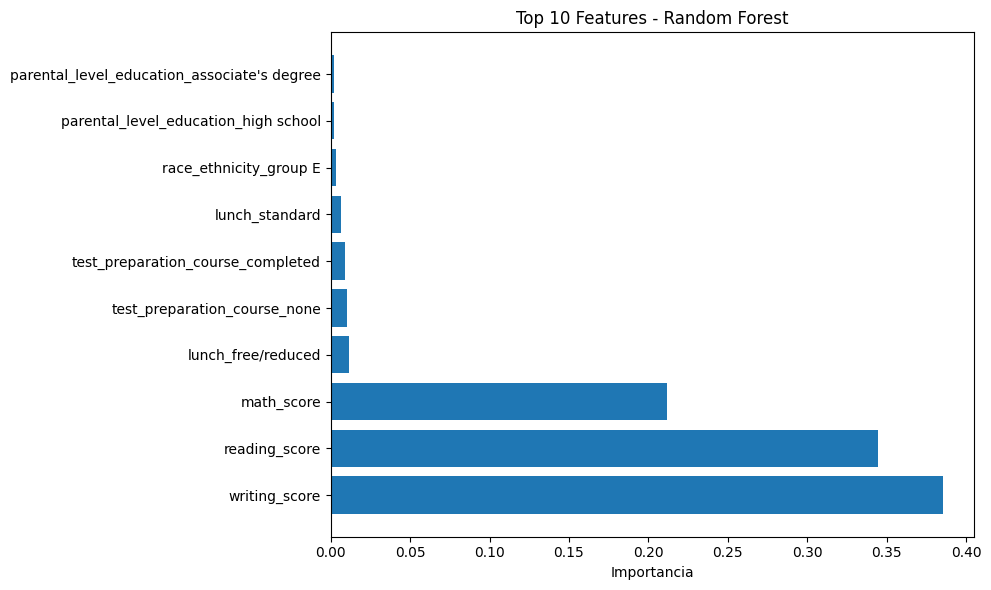

In [0]:
# Top features RF
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(importances['feature'], importances['importance'])
plt.title('Top 10 Features - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()
